In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib
from xgboost import XGBClassifier
import sklearn.metrics as metrics

## Wczytywanie danych

In [2]:
df_australia = pd.read_csv("australia.csv")

In [3]:
df_australia.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
1,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0
2,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0
3,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0
4,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0


## Podział danych na zbiór treningowy i testowy

In [4]:
#Podział zbioru na cechy i target
X = df_australia.drop(['RainTomorrow'], axis = 1)
y = np.array(df_australia['RainTomorrow'])

In [5]:
#Właściwy podział na zbiory treningowe i testowe
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 44)

## Tworzenie modeli

In [6]:
ng = GaussianNB(var_smoothing=1e-10)
lr = LogisticRegression(max_iter=1200)
xgboost = XGBClassifier(max_depth=3,random_state=1)

#### Uczenie modeli

In [7]:
ng.fit(X_train,y_train)
lr.fit(X_train,y_train)
xgboost.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#### Rysowanie krzywych ROC i oblicznie AUC

In [48]:
def draw_test_ROC(X_test,y_test,model, modelname):
  y_test_score = model.predict_proba(X_test)[:,1]
  test_fpr, test_tpr, te_thresholds = metrics.roc_curve(y_test, y_test_score)
  ns_probs = [0 for _ in range(len(y_test))]
  ns_fpr,ns_tpr,ns_treshold = metrics.roc_curve(y_test, ns_probs)
  #Rysowanie ROC
  plt.grid()
  plt.plot(test_fpr,test_tpr, label = "Test ROC")
  plt.plot(ns_fpr,ns_tpr,linestyle = '--')
  plt.legend()
  plt.title("ROC plot for %s"%modelname)
  plt.xlabel("False positive")
  plt.ylabel("True positive")
  plt.rcParams["figure.figsize"] = (10,10)
  print("AUC for test ROC is %s"%metrics.auc(test_fpr, test_tpr))
  fig = metrics.plot_confusion_matrix(model,X_test,y_test,display_labels=['Nie pada', 'Pada'],
                                 cmap=plt.cm.Blues, normalize = 'all')
  fig.ax_.set_title("Confusion matrix for %s" %modelname)

AUC for test ROC is 0.851449623810777


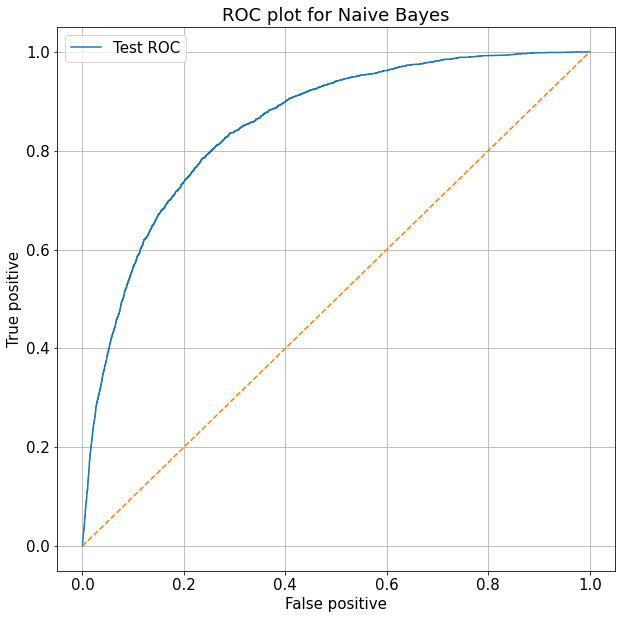

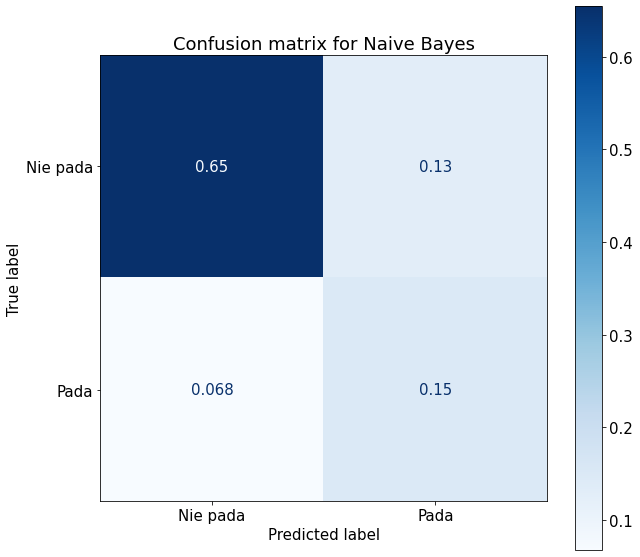

In [49]:
draw_test_ROC(X_test,y_test,ng,"Naive Bayes")

AUC for test ROC is 0.8848292421616977


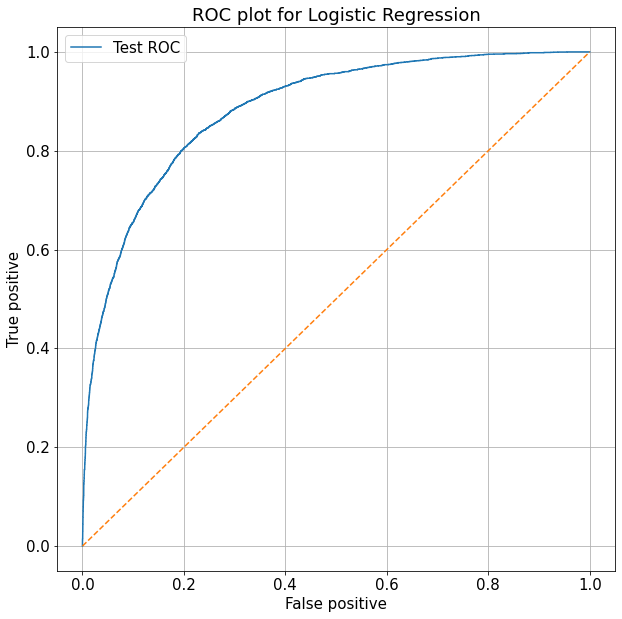

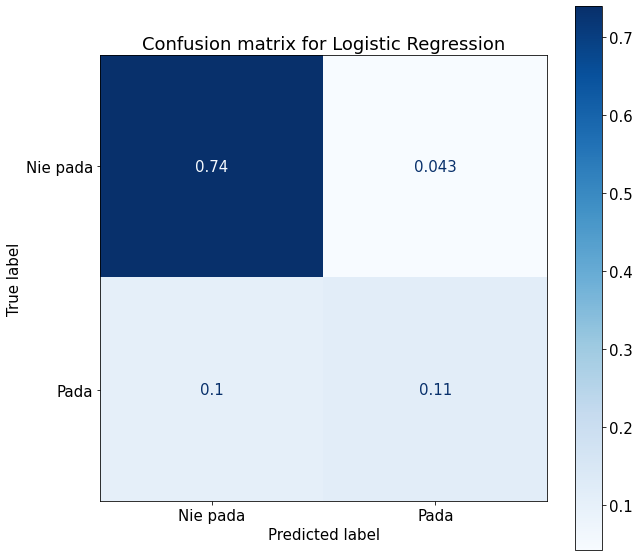

In [50]:
draw_test_ROC(X_test,y_test,lr,"Logistic Regression")

AUC for test ROC is 0.8912281636261278


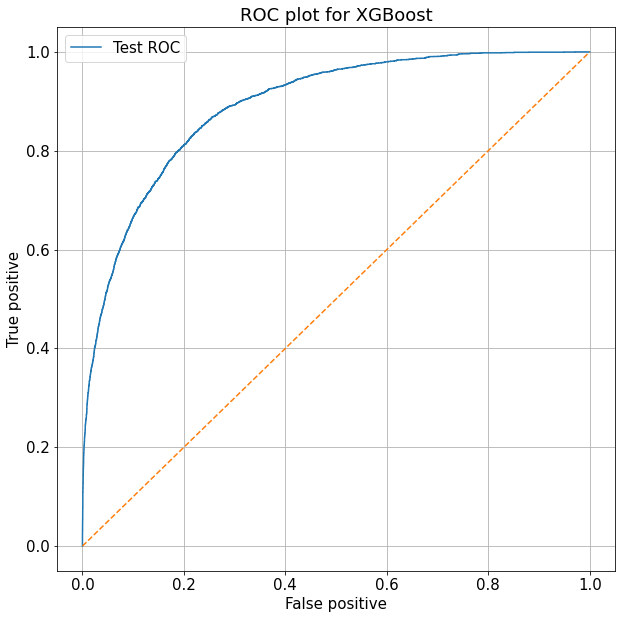

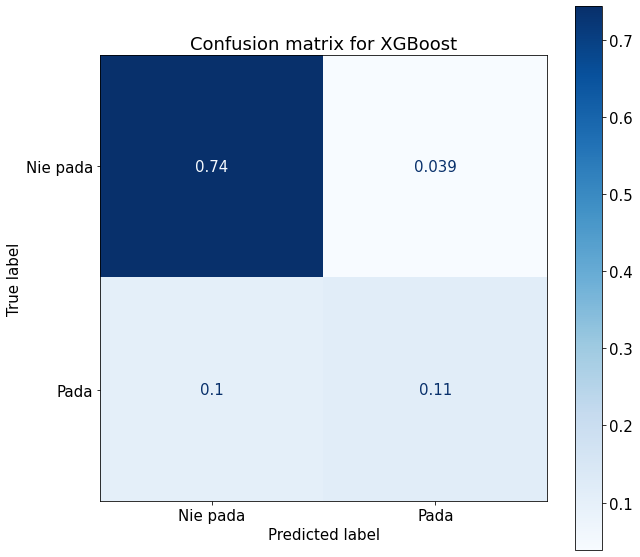

In [51]:
draw_test_ROC(X_test,y_test,xgboost,"XGBoost")

#### Testowanie Precision, Accuracy i Recall na kroswalidacji

In [12]:
X_train_test=pd.concat((X_train,X_test))
y_train_test=np.concatenate((y_train,y_test), axis=0)

In [26]:
def crossval(X,y,model):
  cross_acc = cross_val_score(model, X, y, scoring='accuracy', cv = 15)
  cross_pre = cross_val_score(model, X, y, scoring='precision', cv = 15)
  cross_rec = cross_val_score(model, X, y, scoring='recall', cv = 15)
  cross = pd.DataFrame({'Accuracy' : cross_acc,
                        'Precision' : cross_pre,
                       'Recall':cross_rec})
  cross = pd.melt(cross)
  return cross

In [27]:
cross_lr = crossval(X_train_test,y_train_test,lr)
cross_ng = crossval(X_train_test,y_train_test,ng)
cross_xb = crossval(X_train_test,y_train_test,xgboost)

In [28]:
cross_lr['type'] = ["Logistic regression"] * 45
cross_ng['type'] = ["Naive Bayess"] * 45
cross_xb['type'] = ['XGBoost'] * 45

In [29]:
crossvalidations = pd.concat((cross_lr,cross_ng,cross_xb))
crossvalidations = crossvalidations.rename(columns={'variable':'Scoring'})

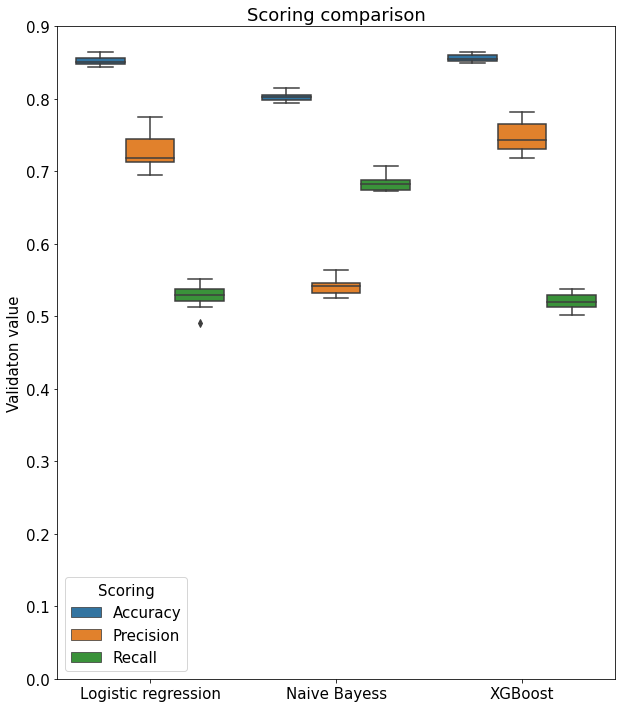

In [30]:
ax = sns.boxplot(data = crossvalidations, 
                 x = crossvalidations.type, y = crossvalidations.value, hue = crossvalidations.Scoring)
ax.set(ylim = (0,0.9))
matplotlib.rcParams['figure.figsize'] = [10,12]
matplotlib.rcParams.update({'font.size': 15})
plt.title("Scoring comparison")
plt.ylabel("Validaton value")
plt.xlabel("")

plt.show()

Jak widać, ciężko wskazać jednoznacznego zwycięzcę, biorąc jednak pod uwagę AUC, i accuracy wskazałbym na XGBoost.